<a href="https://colab.research.google.com/github/siabang35/Predict-TLKM-Stock-with-ARIMA/blob/choice/Goldfarb_Wildan_Assyidiq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Wildan Assyidiq

Prodi : Teknik Informatika

Kelas : Goldfarb


##Prediksi Harga Saham TLKM(TELKOM) dengan Menggunakan Model ARIMA##

# 1.**Import Library dan Import Dataset** 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape
from datetime import datetime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TLKM.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,3980.0,3980.0,3980.0,3980.0,3310.131592,0.0
1,2017-01-03,3950.0,3990.0,3920.0,3950.0,3285.180664,71660600.0
2,2017-01-04,3880.0,3980.0,3880.0,3950.0,3285.180664,68494500.0
3,2017-01-05,3960.0,4030.0,3940.0,3950.0,3285.180664,74018400.0
4,2017-01-06,3970.0,4010.0,3960.0,4000.0,3326.765381,44136900.0


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1417,2022-08-26,4510.0,4540.0,4480.0,4490.0,4490.0,184317100.0
1418,2022-08-29,4370.0,4550.0,4360.0,4520.0,4520.0,101529800.0
1419,2022-08-30,4580.0,4620.0,4480.0,4480.0,4480.0,118884300.0
1420,2022-08-31,4420.0,4600.0,4420.0,4560.0,4560.0,175300400.0
1421,2022-09-01,4560.0,4650.0,4530.0,4580.0,4580.0,120871700.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1422 non-null   object 
 1   Open       1421 non-null   float64
 2   High       1421 non-null   float64
 3   Low        1421 non-null   float64
 4   Close      1421 non-null   float64
 5   Adj Close  1421 non-null   float64
 6   Volume     1421 non-null   float64
dtypes: float64(6), object(1)
memory usage: 77.9+ KB


## **2.Melakukan Cleaning pada Dataset** 

Disini Saya Menggunakan Data Harga Penutupan Saham TLKM ['Close'] pada Tahun 2022

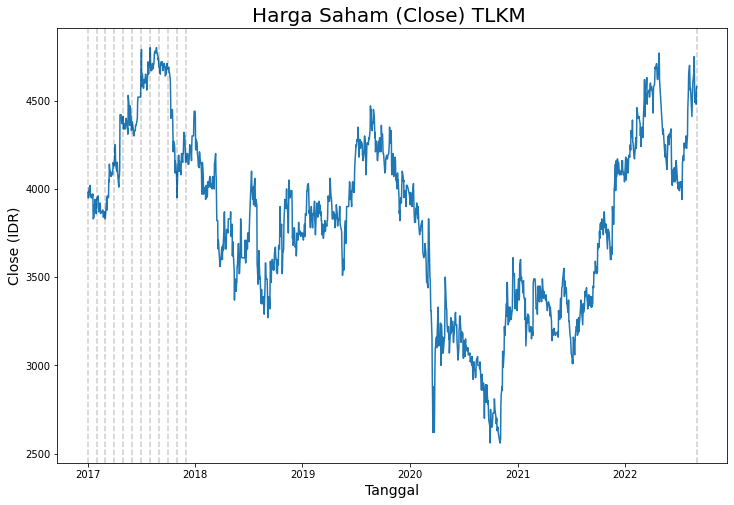

In [ ]:
df_close = df['Close']
df_close.index = pd.to_datetime(df.Date)
awal = datetime(2017, 1,2)
akhir = datetime(2022, 9, 1)
df_close = df_close[awal:akhir]
df_close = df_close.asfreq(freq='D')
df_close.interpolate(inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_close)
plt.title('Harga Saham (Close) TLKM ', fontsize=20)
plt.xlabel('Tanggal', fontsize=14)
plt.ylabel('Close (IDR)', fontsize=14)
for month in range(1, 13):
    plt.axvline(pd.to_datetime('2017-' + str(month) + '-02'), color='k', linestyle='--', alpha=0.2)
plt.axvline(pd.to_datetime('2022-09-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

## **3.Cek Stationeritas pada Dataset,Seasonality, Orde AR dan Orde MA** 

**3.1 Melakukan pemecahan pada komponen pada Data time series**

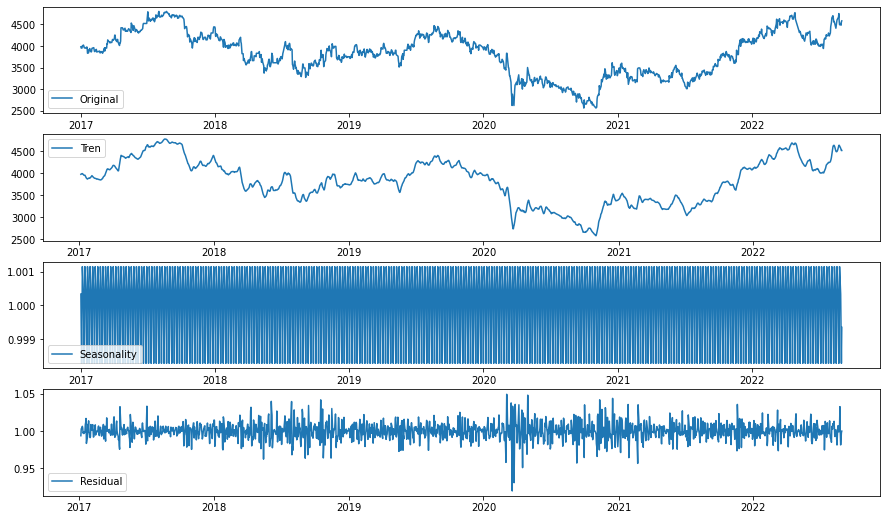

In [ ]:
# Dekomposisi
from statsmodels.tsa.seasonal import seasonal_decompose

dekomposisi = seasonal_decompose(df_close, model='multiplicative')
trend = dekomposisi.trend
seasonal = dekomposisi.seasonal
residu = dekomposisi.resid

fig, ax = plt.subplots(4, 1, figsize=(15, 9))
ax[0].plot(df_close, label='Original')
ax[0].legend(loc='best')
ax[1].plot(trend, label='Tren')
ax[1].legend(loc='best')
ax[2].plot(seasonal, label='Seasonality')
ax[2].legend(loc='best')
ax[3].plot(residu, label='Residual')
ax[3].legend(loc='best')
plt.show()

**3.2 Cek Stasioneritas pada (Orde D) dengan Ad-Fuller, Plotting dengan ACF & PACF**

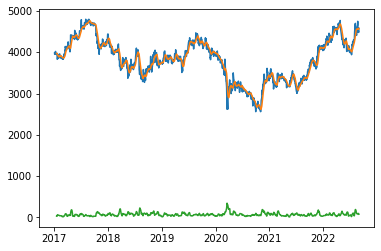

In [ ]:
# Kita coba visualisasikan hasil rolling
rollingmean = df_close.rolling(15).mean()
rollingstd = df_close.rolling(15).std()
plt.plot(df_close, label='Original')
plt.plot(rollingmean, label='Mean')
plt.plot(rollingstd, label='std')
plt.show()

In [ ]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

hasil_adfuller = adfuller(df_close.dropna())

print('ADF Statistik: %f' % hasil_adfuller[0])
print(f'p-value: {hasil_adfuller[1]}')

ADF Statistik: -1.832418
p-value: 0.3644900078329857


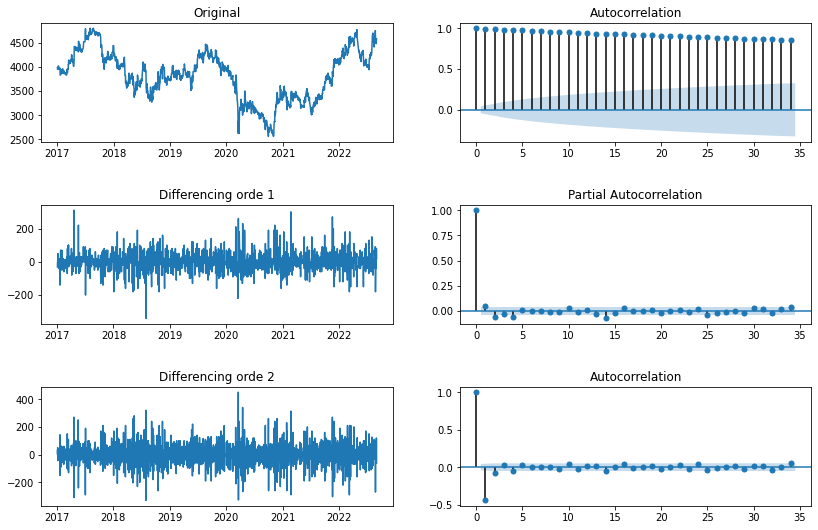

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes[0, 0].plot(df_close)
axes[0, 0].set_title('Original')
plot_acf(df_close, ax=axes[0, 1])

axes[1, 0].plot(df_close.diff())
axes[1, 0].set_title('Differencing orde 1')
plot_pacf(df_close.diff().dropna(), ax=axes[1, 1])

axes[2, 0].plot(df_close.diff().diff())
axes[2, 0].set_title('Differencing orde 2')
plot_acf(df_close.diff().diff().dropna(), ax=axes[2, 1])

fig.tight_layout(pad=3.0)

plt.show()

**3.3 Menentukan lag awal AR pada plot PACF** 

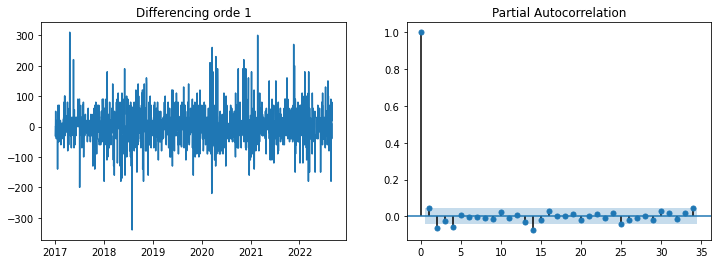

In [ ]:
# PACF plot untuk menentukan p (komponen AR)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(df_close.diff())
axes[0].set_title('Differencing orde 1')
plot_pacf(df_close.diff().dropna(), ax=axes[1])

plt.show()

**3.4 Menentukan Lag awal MA pada plot ACF**  

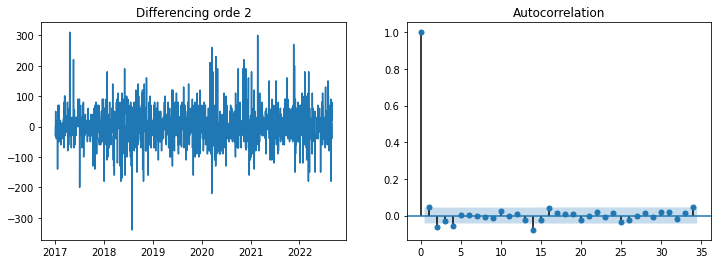

In [ ]:
# ACF plot untuk menentukan q (komponen MA)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(df_close.diff())
axes[0].set_title('Differencing orde 2')
plot_acf(df_close.diff().dropna(), ax=axes[1])

plt.show()

## **4.MODELLING** 

**4.1 Model dengan ARIMA sebagai baseline**

In [ ]:
import statsmodels as tsa
import statsmodels.api as sm
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data = df_close[:'2022-08-01']
test_data = df_close['2022-09-01':]


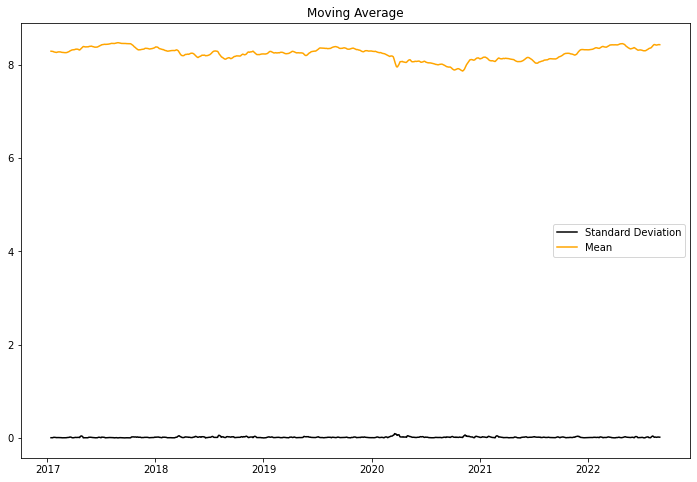

In [ ]:
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="orange", label = "Mean")
plt.legend(loc='best')
plt.show()

In [ ]:
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]

In [ ]:
# Model ARIMA (1, 1, 2) langsung ke df
model2 = sm.tsa.arima.ARIMA(train_data, order=(1, 1, 2))
model_fit = model2.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1652
Model:                 ARIMA(1, 1, 2)   Log Likelihood                4676.053
Date:                Sat, 17 Sep 2022   AIC                          -9344.106
Time:                        16:16:30   BIC                          -9322.469
Sample:                    01-05-2017   HQIC                         -9336.084
                         - 07-14-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4013      0.229      1.753      0.080      -0.047       0.850
ma.L1         -0.3451      0.228     -1.516      0.130      -0.791       0.101
ma.L2         -0.0941      0.018     -5.203      0.000      -0.130      -0.059
sigma2         0.0002   3.32e-06     61.163      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3732.14
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

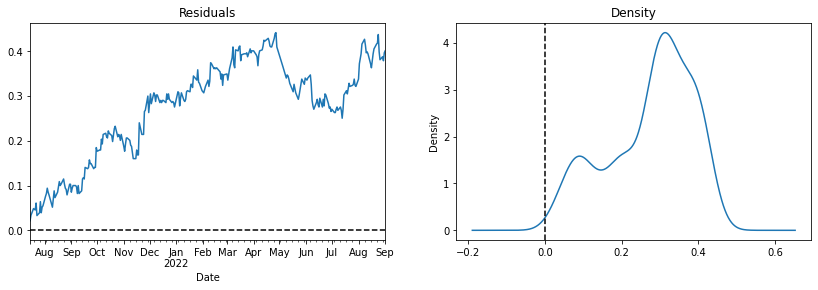

In [ ]:
pred = model_fit.predict(test_data.index[0], test_data.index[-1])
residuals = test_data - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

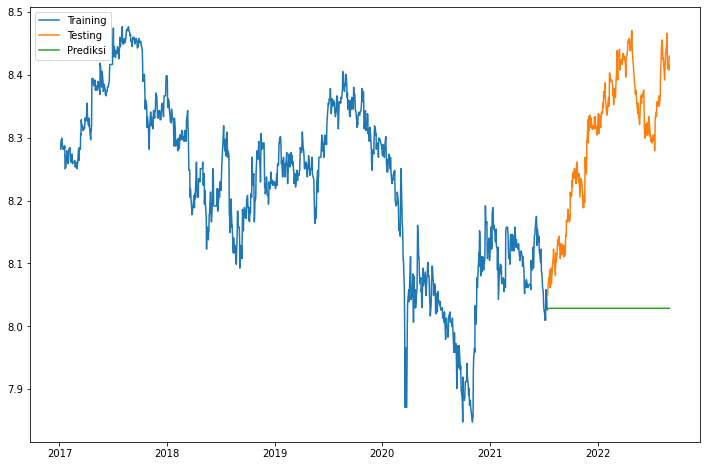

MAPE: 3.29%
RMSE: 0.2954760496177569


In [ ]:
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(test_data, pred) * 100, 2)))
print('RMSE:', mse(test_data, pred, squared=False))

## **5.TUNING DAN EVALUASI MODEL**

**5.1 Coba dengan Differencing=2**

In [ ]:
# Model ARIMA (1, 2, 1) langsung ke df
model3 = ARIMA(train_data, order=(1, 2, 1)).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Close   No. Observations:                 1650
Model:                 ARIMA(1, 2, 1)   Log Likelihood                4664.136
Method:                       css-mle   S.D. of innovations              0.014
Date:                Sat, 17 Sep 2022   AIC                          -9320.271
Time:                        16:16:32   BIC                          -9298.637
Sample:                    01-07-2017   HQIC                         -9312.250
                         - 07-14-2021                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -3.16e-07   7.94e-07     -0.398      0.691   -1.87e-06    1.24e-06
ar.L1.D2.Close     0.0705      0.025      2.868      0.004       0.022       0.119
ma.L1.D2.Close    -1.0000      0.002   -622.570      0.000      -1.003      -0.997
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           14.1840           +0.0000j           14.1840            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

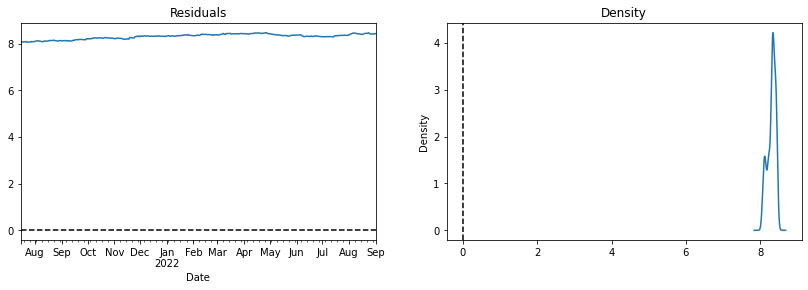

In [ ]:
# Plot residual errors
pred = model3.predict(test_data.index[0], test_data.index[-1])
residuals = test_data - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

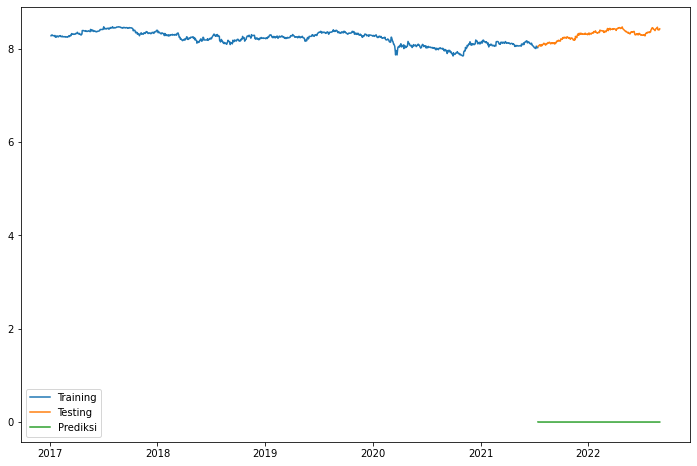

MAPE: 100.0%
RMSE: 8.303807617258977


In [ ]:
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(test_data, pred) * 100, 2)))
print('RMSE:', mse(test_data, pred, squared=False))

**5.2 Tuning untuk menentukan nilai p, d, q dengan auto_arima**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 9.8 MB 33.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
# Model ARIMA (p, d, q) menggunakan auto_arima()
import pmdarima as pm

model4 = pm.auto_arima(train_data, start_p=0, start_q=0,
                       test='adf', # pakai adftest untuk mencari 'd' optimum
                       max_p=4, max_q=4,
                       m=1, # frekuensi
                       d=None, # model yang akan mencari
                       seasonal=False,
                       start_P=0,
                       D=0,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )
model4.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9332.280, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9336.223, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9336.924, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9334.088, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9335.442, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9340.229, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9341.933, Time=1.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9341.047, Time=1.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9340.467, Time=2.58 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9341.290, Time=2.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9343.372, Time=2.71 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9340.624, Time=0.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9339.946, Time=3.78 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-9342.216, Time=0.79 sec
 ARIMA(3,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1652
Model:               SARIMAX(2, 1, 1)   Log Likelihood                4676.565
Date:                Sat, 17 Sep 2022   AIC                          -9345.129
Time:                        16:17:18   BIC                          -9323.493
Sample:                    01-05-2017   HQIC                         -9337.108
                         - 07-14-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8100      0.099      8.165      0.000       0.616       1.004
ar.L2         -0.1070      0.019     -5.590      0.000      -0.145      -0.070
ma.L1         -0.7492      0.100     -7.477      0.000      -0.946      -0.553
sigma2         0.0002   3.31e-06     61.166      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3697.19
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

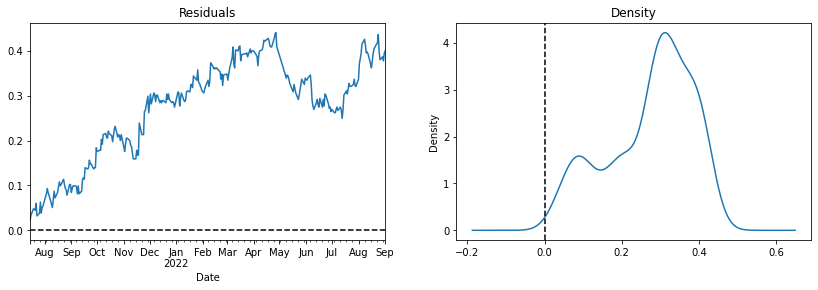

In [ ]:
# Plot residual errors
pred = model4.predict(528)
pred = pd.Series(pred, index=test_data.index)

residuals = test_data - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

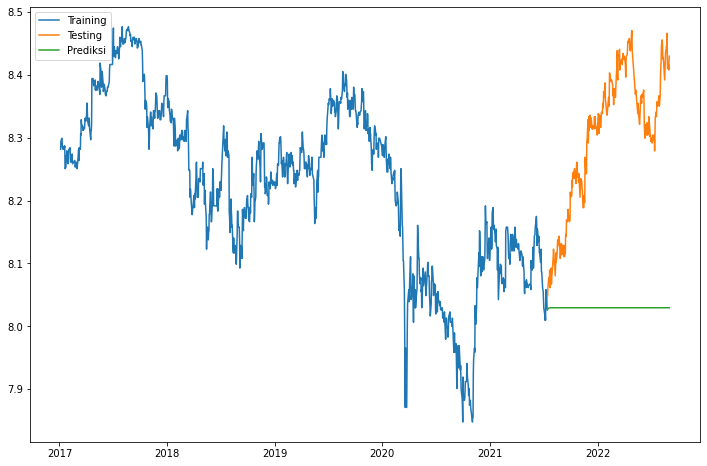

MAPE: 3.28%
RMSE: 0.2946556385275624


In [ ]:
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(test_data, pred) * 100, 2)))
print('RMSE:', mse(test_data, pred, squared=False))

**5.3 Cek Seasonality dengan SARIMA** 

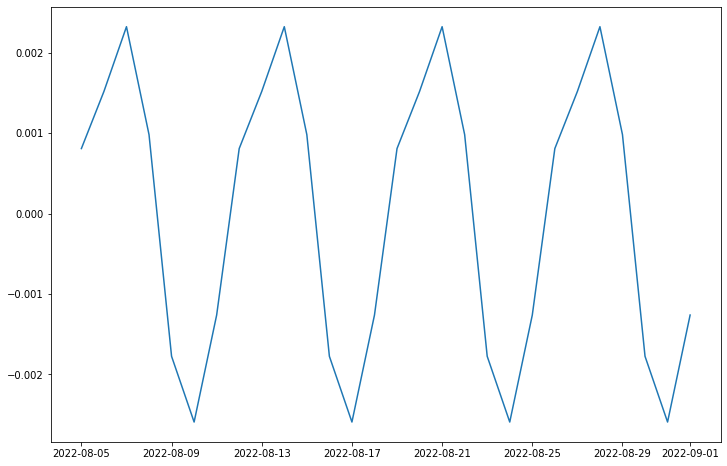

In [ ]:
# Kita coba differencing 4
plt.plot(seasonal['2022-08-01':'2022-09-01'].diff(4))
plt.show()

In [ ]:
model5 = pm.auto_arima(train_data, start_p=1, start_q=1,
                       test='adf', # pakai adftest untuk mencari 'd' optimum
                       max_p=3, max_q=3,
                       m=4, # frekuensi
                       d=None, # model yang akan mencari
                       seasonal=True,
                       start_P=0,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )
model5.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=10.97 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=-7022.183, Time=0.44 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=-8722.452, Time=4.64 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=-8275.627, Time=6.06 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=-7023.429, Time=0.35 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=-8308.683, Time=1.07 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=-8905.487, Time=13.35 sec
 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=-9185.290, Time=9.88 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=5.79 sec
 ARIMA(1,0,0)(2,1,2)[4] intercept   : AIC=inf, Time=9.45 sec
 ARIMA(1,0,0)(1,1,2)[4] intercept   : AIC=inf, Time=7.58 sec
 ARIMA(0,0,0)(2,1,1)[4] intercept   : AIC=-7028.370, Time=2.35 sec
 ARIMA(2,0,0)(2,1,1)[4] intercept   : AIC=-9081.765, Time=8.22 sec
 ARIMA(1,0,1)(2,1,1)[4] intercept   : AIC=-9065.021, Time=7.98 sec
 ARIMA(0,0,1)(2,1,1)[4] intercept   : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1652
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 4)   Log Likelihood                4598.645
Date:                             Sat, 17 Sep 2022   AIC                          -9185.290
Time:                                     16:19:07   BIC                          -9152.846
Sample:                                 01-05-2017   HQIC                         -9173.260
                                      - 07-14-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -9.59e-06   1.68e-05     -0.569      0.569   -4.26e-05    2.34e-05
ar.L1          0.9921      0.003    296.531      0.000       0.986       0.999
ar.S.L4       -0.3028      0.024    -12.797      0.000      -0.349      -0.256
ar.S.L8       -0.0084      0.023     -0.370      0.712      -0.053       0.036
ma.S.L4       -0.9591      0.008   -113.009      0.000      -0.976      -0.942
sigma2         0.0002   3.95e-06     55.659      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   6.25   Jarque-Bera (JB):              2771.14
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

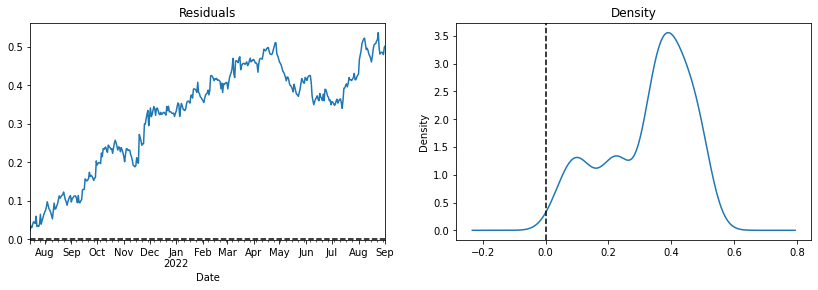

In [ ]:
# Plot residual errors
pred = model5.predict(528)
pred = pd.Series(pred, index=test_data.index)

residuals = test_data - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

**5.4 Melakukan Rolling atau Forecasting Origin dengan ARIMA** 

In [ ]:
pred3 = test_data.copy()

for index in tqdm(test_data.index):
    train_data = df_close[:index - timedelta(days=1)]
    
    


100%|██████████| 414/414 [00:00<00:00, 4559.84it/s]


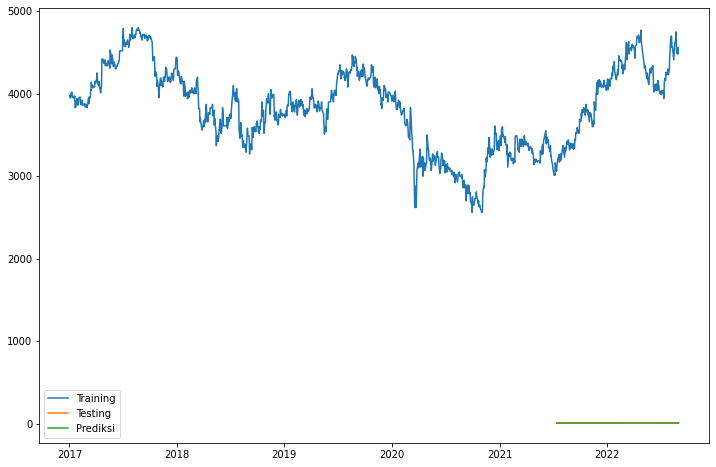

In [ ]:
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Testing')
plt.plot(pred3, label='Prediksi')
plt.legend()
plt.show()


## **6.PREDIKSI KENAIKAN HARGA SAHAM TLKM** 

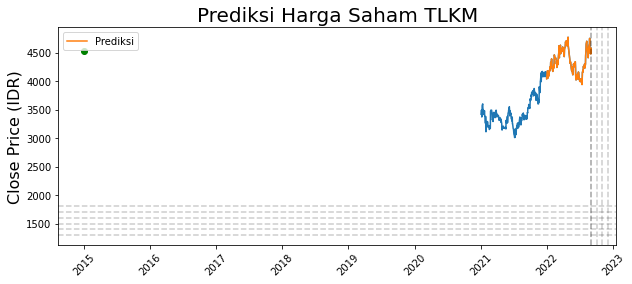

In [ ]:
model_final = sm.tsa.arima.ARIMA(df_close, order=(1, 2, 1)).fit()
# Prediksi September Tanggal 2 - 5
sep = model_final.predict('2022-08-30', '2022-09-01')

fig = plt.figure(figsize=(10, 4))
plt.plot(df_close['2021-01-02':])
plt.plot(df_close.append(sep)['2021-12-30':], label='Prediksi')
plt.plot(datetime(2015, 1, 2), sep['2022-08-30'], marker='o', color='green')
plt.xticks(rotation=45)
for month in range(9, 13):
    plt.axvline(pd.to_datetime('2022-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(pd.to_datetime('2022-09-01'), color='k', linestyle='--', alpha=0.2)
for num in range(1300, 1800 + 1, 100):
    plt.axhline(num, color='k', linestyle='--', alpha=0.2)
plt.title('Prediksi Harga Saham TLKM', fontsize=20)
plt.ylabel('Close Price (IDR)', fontsize=16)
plt.legend(loc=2)
fig.savefig('prediksi.png', bbox_inches='tight')
plt.show()

## **KESIMPULAN** ##
Model terbaik yang bisa digunakan untuk memprediksi adalah ARIMA(1, 2, 1) 

Harga saham TLKM pada 02-06 September 2022 diprediksi naik menuju nilai sekitar IDR 4590-4600